# Minimum Energy Double Pendulum Swing Up

This is a simple demonstration of trajectory optimization using opty. Given two link pendulum attached to a sliding cart that can be actuated by a lateral force, we look for a minimal energy method to swing the pendulum to a vertical position in a specific time interval.

The following diagram shows an N link pendulum.

![](n-pendulum-with-cart.svg)

Our system is a two link version of this.

# Setup

First, import the necessary packages, modules, functions, and classes.

In [1]:
import sympy as sm
import sympy.physics.mechanics as me
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from pydy.models import n_link_pendulum_on_cart
from opty.direct_collocation import Problem
from opty.utils import parse_free

import utils

:0: FutureWarning: IPython widgets are experimental and may change in the future.


The following will initialize pretty printing of the symbolics.

In [2]:
me.init_vprinting(use_latex="mathjax")

# Model

PyDy includes a canned model for this system. We can create a two link version like so:

In [3]:
pendulum_sys = n_link_pendulum_on_cart(n=2, cart_force=True)

/home/moorepants/anaconda/envs/inverted-pendulum-id/lib/python2.7/site-packages/pydy/system.py:102: PyDyFutureWarning: PyDy System is experimental and may change in the future.
  warnings.warn(msg, PyDyFutureWarning)


The system has six states, one exogenous specified input, six and constants. 

In [4]:
num_states = len(pendulum_sys.states)

In [5]:
pendulum_sys.states

[q₀, q₁, q₂, u₀, u₁, u₂]

In [6]:
pendulum_sys.specifieds_symbols

set([F])

In [7]:
pendulum_sys.constants_symbols

set([g, l₀, l₁, m₀, m₁, m₂])

opty only requires that the equations of motion be provided in implicit form. We will make use of the "full" mass matrix and forcing vector.

In [8]:
M = sm.trigsimp(pendulum_sys.eom_method.mass_matrix_full)
M

⎡1  0  0            0                      0                      0          ⎤
⎢                                                                            ⎥
⎢0  1  0            0                      0                      0          ⎥
⎢                                                                            ⎥
⎢0  0  1            0                      0                      0          ⎥
⎢                                                                            ⎥
⎢0  0  0      m₀ + m₁ + m₂       -l₀⋅(m₁ + m₂)⋅sin(q₁)     -l₁⋅m₂⋅sin(q₂)    ⎥
⎢                                                                            ⎥
⎢                                     2        2                             ⎥
⎢0  0  0  -l₀⋅(m₁ + m₂)⋅sin(q₁)     l₀ ⋅m₁ + l₀ ⋅m₂     l₀⋅l₁⋅m₂⋅cos(q₁ - q₂)⎥
⎢                                                                            ⎥
⎢                                                                2           ⎥
⎣0  0  0     -l₁⋅m₂⋅sin(q₂)      l₀⋅l₁⋅m₂⋅cos(q₁ - q

In [9]:
f = sm.trigsimp(pendulum_sys.eom_method.forcing_full)
f

⎡                             u₀                              ⎤
⎢                                                             ⎥
⎢                             u₁                              ⎥
⎢                                                             ⎥
⎢                             u₂                              ⎥
⎢                                                             ⎥
⎢        2                   2                   2            ⎥
⎢l₀⋅m₁⋅u₁ ⋅cos(q₁) + l₀⋅m₂⋅u₁ ⋅cos(q₁) + l₁⋅m₂⋅u₂ ⋅cos(q₂) + F⎥
⎢                                                             ⎥
⎢     ⎛                                      2             ⎞  ⎥
⎢ -l₀⋅⎝g⋅m₁⋅cos(q₁) + g⋅m₂⋅cos(q₁) + l₁⋅m₂⋅u₂ ⋅sin(q₁ - q₂)⎠  ⎥
⎢                                                             ⎥
⎢                ⎛                  2             ⎞           ⎥
⎣          l₁⋅m₂⋅⎝-g⋅cos(q₂) + l₀⋅u₁ ⋅sin(q₁ - q₂)⎠           ⎦

The implicit expression for the right hand side of the equations of motion can be computed as such:

$$
\mathbf{0} = \mathbf{g}(\dot{\mathbf{x}}, \mathbf{x}, \mathbf{r}, \mathbf{p}, t) = \mathbf{M} \dot{\mathbf{x}} - \mathbf{f}
$$

In [10]:
eom_expr = sm.trigsimp(M * sm.Matrix(pendulum_sys.states).diff() - f)
eom_expr

⎡                                                               -u₀ + q₀̇     
⎢                                                                             
⎢                                                               -u₁ + q₁̇     
⎢                                                                             
⎢                                                               -u₂ + q₂̇     
⎢                                                                             
⎢            2                   2                                            
⎢  - l₀⋅m₁⋅u₁ ⋅cos(q₁) - l₀⋅m₂⋅u₁ ⋅cos(q₁) - l₀⋅(m₁ + m₂)⋅sin(q₁)⋅u₁̇ - l₁⋅m₂⋅
⎢                                                                             
⎢                                                          ⎛                  
⎢l₀⋅l₁⋅m₂⋅cos(q₁ - q₂)⋅u₂̇ - l₀⋅(m₁ + m₂)⋅sin(q₁)⋅u₀̇ + l₀⋅⎝g⋅m₁⋅cos(q₁) + g⋅m
⎢                                                                             
⎢                                ⎛                 2

# NLP Problem Setup

Here we set some numerical values for the constant parameters:

In [11]:
pendulum_sys.constants = {p: 9.81 if p.name == 'g' else 1.0 for p in pendulum_sys.constants_symbols}
pendulum_sys.constants

{g: 9.81, l₀: 1.0, l₁: 1.0, m₀: 1.0, m₁: 1.0, m₂: 1.0}

We will try to swing the pendulum up in 10 seconds and will discretize time with 500 nodes.

In [12]:
duration = 10.0
num_nodes = 500
interval_value = duration / (num_nodes - 1)

## Objective

Our objective is to use minimal energy to swing the pendulum to a vertical stationary state by 10 seconds. One way to approach this is to minimize the square of the applied force:

$$ J(\theta) = h \sum F_i^2 $$

Here we create a function for the objective and its gradient:

In [13]:
def obj(free):
    """Minimize the sum of the squares of the control force."""
    F = free[num_states * num_nodes:]
    return interval_value * np.sum(F**2)


def obj_grad(free):
    grad = np.zeros_like(free)
    grad[num_states * num_nodes:] = 2.0 * interval_value * free[num_states * num_nodes:]
    return grad

## Task Constraints

We also need some constraints to specify what state we want the pendulum to be in at the start and end of the task. At the beginning and end we want the pendulum to be stationary, i.e. the velocities should be zero. At the beginning the pendulum should be hanging down, i.e. $q(10)=-\pi/2$ and at the end the pendulum should vertical, i.e. $q(0) = \pi/2$. These constraints are specified by "instance constraints", i.e. constraints specified for a single instance of time.

In [14]:
target_angle = sm.pi / 2

In [15]:
q0, q1, q2, u0, u1, u2 = [x.__class__ for x in pendulum_sys.states]
instance_constraints = (q0(0.0),
                        q1(0.0) + target_angle,
                        q1(duration) - target_angle,
                        q2(0.0) + target_angle,
                        q2(duration) - target_angle,
                        u0(0.0),
                        u0(duration),
                        u1(0.0),
                        u1(duration),
                        u2(0.0),
                        u2(duration))

instance_constraints

⎛                   π             π            π             π                
⎜q₀(0.0), q₁(0.0) + ─, q₁(10.0) - ─, q₂(0.0) + ─, q₂(10.0) - ─, u₀(0.0), u₀(10
⎝                   2             2            2             2                

                                         ⎞
.0), u₁(0.0), u₁(10.0), u₂(0.0), u₂(10.0)⎟
                                         ⎠

## Construct the Problem

The Problem object available in opty is now initialized with all of the problem setup information.

In [16]:
prob = Problem(obj, obj_grad, eom_expr, pendulum_sys.states,
               num_nodes, interval_value,
               known_parameter_map=pendulum_sys.constants,
               instance_constraints=instance_constraints)

IPOPT options can be added. The following sets the linear solver.

In [17]:
prob.addOption('linear_solver', 'ma57')

# Solve the Problem

We then supply a random initial guess.

In [18]:
initial_guess = np.random.random(prob.num_free)

Alternatively, you can load a previously found optimal solution.

In [19]:
initial_guess = np.load('dp-solution.npy')

The problem can then be solved by calling the `solve()` method with the initial guess. The solution is returned along with some IPOPT info and stats.

In [20]:
solution, info = prob.solve(initial_guess)

In [21]:
prob.obj(solution)

616.919724446

Uncomment this if you want to save an optimal solution.

In [22]:
#np.save('dp-solution', solution)

# Plot the Results

In [23]:
x, r, p = parse_free(solution, prob.collocator.num_states,
                     prob.collocator.num_unknown_input_trajectories, num_nodes)

In [24]:
time = np.linspace(0.0, duration, num=num_nodes)

In [25]:
%matplotlib inline
figsize(12, 9)

## Trajectories

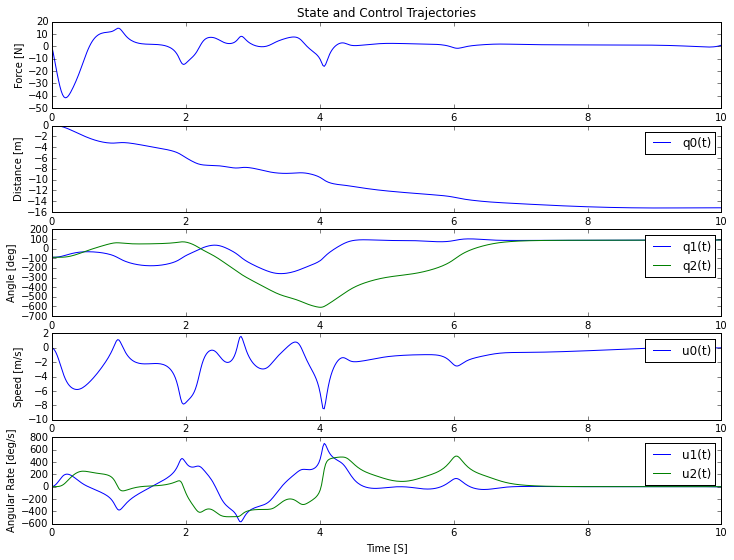

In [26]:
fig, axes = plt.subplots(5)

axes[0].set_title('State and Control Trajectories')

axes[0].plot(time, r)
axes[0].set_ylabel('Force [N]')

axes[1].plot(time, x[0])
axes[1].set_ylabel('Distance [m]')
axes[1].legend(pendulum_sys.states[0:1])

axes[2].plot(time, np.rad2deg(x[1:3].T))
axes[2].set_ylabel('Angle [deg]')
axes[2].legend(pendulum_sys.states[1:3])

axes[3].plot(time, x[3])
axes[3].set_ylabel('Speed [m/s]')
axes[3].legend(pendulum_sys.states[3:4])

axes[4].plot(time, np.rad2deg(x[4:].T))
axes[4].set_ylabel('Angular Rate [deg/s]')
axes[4].legend(pendulum_sys.states[4:])
axes[4].set_xlabel('Time [S]')

## Constraint violations

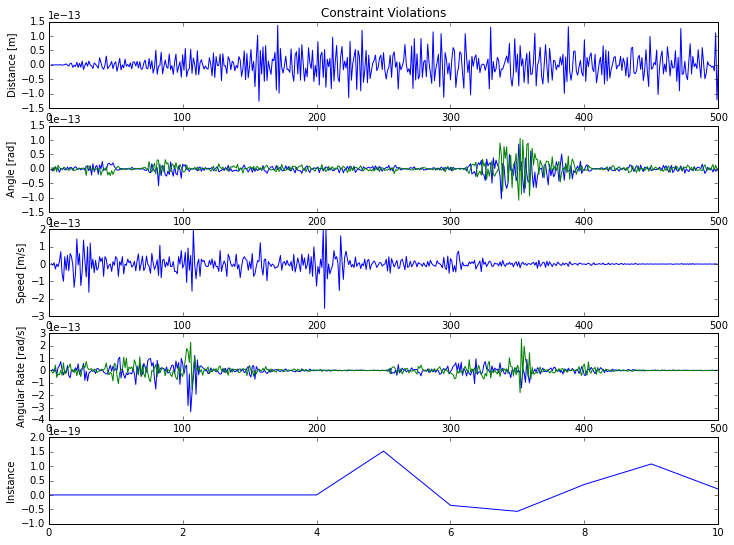

In [27]:
con_violations = prob.con(solution)
con_nodes = range(2, num_nodes + 1)
N = len(con_nodes)

fig, axes = plt.subplots(5)

axes[0].set_title('Constraint Violations')
axes[0].plot(con_nodes, con_violations[:N])
axes[0].set_ylabel('Distance [m]')

axes[1].plot(con_nodes, con_violations[N:3 * N].reshape(N, 2))
axes[1].set_ylabel('Angle [rad]')

axes[2].plot(con_nodes, con_violations[3 * N:4 * N])
axes[2].set_ylabel('Speed [m/s]')

axes[3].plot(con_nodes, con_violations[4 * N:6 * N].reshape(N, 2))
axes[3].set_ylabel('Angular Rate [rad/s]')
axes[3].set_xlabel('Node Number')

axes[4].plot(con_violations[6 * N:])
axes[4].set_ylabel('Instance')

# Motion Visualization

In [28]:
scene = utils.pydy_n_link_pendulum_scene(pendulum_sys)

/home/moorepants/anaconda/envs/inverted-pendulum-id/lib/python2.7/site-packages/pydy/viz/camera.py:73: PyDyUserWarning: Rotation of Perspective Camera does not work properly in the visualiser.
  warnings.warn(msg, PyDyUserWarning)


In [29]:
scene.states_trajectories = x.T

In [30]:
scene.frames_per_second = 1.0 / interval_value

In [31]:
scene.display_ipython()

# Version Information

In [32]:
%install_ext version_information.py
%load_ext version_information
%version_information numpy, sympy, scipy, matplotlib, pydy, opty

Installed version_information.py. To use it, type:
  %load_ext version_information


Software versions
Python 2.7.10 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 3.2.0
OS Linux 3.13.0 55 generic x86_64 with debian jessie sid
numpy 1.9.2
sympy 0.7.7.dev
scipy 0.15.1
matplotlib 1.4.3
pydy 0.3.0
opty 0.1.0
Wed Jul 08 09:20:11 2015 CDT